# Implement SGD for linear regression 

### Objective: 
Manually implement linear regression using SGD algorithm for boston house price dataset and compare the results with sklearn SGDRegressor implementation.

In [0]:
import warnings
warnings.filterwarnings("ignore")
from sklearn.datasets import load_boston
from random import seed
from random import randrange
from csv import reader
from math import sqrt
from sklearn import preprocessing
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import SGDRegressor
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error

In [0]:
X = load_boston().data
Y = load_boston().target

In [0]:
scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

In [0]:
# Define a function to plot the results
def scatter_plot(y_true, y_pred):
    plt.grid(b=True)
    plt.scatter(y_true, y_pred)
    plt.title("Actual prices Vs. Predicted prices")
    plt.xlabel("Actual prices")
    plt.ylabel("Predicted prices")
    plt.show()

In [0]:
clf = SGDRegressor()
clf.fit(X, Y)
print(mean_squared_error(Y, clf.predict(X)))

22.84912407315616


## Implementing our own SGD regressor algorithm

To implement SGD algorithm we will define a function that we can repeatedly use. 

The implementation details for SGD are given below:

1. First initialize the weight and intercept term with initial random values.
2. Decide for the number of iterations for which the SGD algorithm will run to find the minima
3. Repeatedly divide the dataset into a fixed number of points to create a batch for every iteration
4. Compute the partial derivatives for each batch
5. Update the weight and intercept term at the end of each iteration
6. Update the learning rate at the very end of the iteration

So first I will initialize the weight (w) and intercept term (b).

In [0]:
# Create a dataframe for the boston dataset for ease of use
boston = pd.DataFrame(data=X)
boston['Price'] = Y
data = boston.drop('Price', axis=1)
target = boston['Price']

In [0]:
def sgd_implementation(X, learning_rate=0.01, n_iterations=100):
    '''
        In this SGD implementation, X is a dataframe
        - learning_rate has a default value of 0.01 and will decrease with
          each iteration accoring to the below formula:
                learning_rate = learning_rate/2
        
        - n_iterations is the number of iterations with a default value of 100.
          We can change the number of iterations to see
          how the performance of the model changes with higher iterations.
          
          This function will return the optimal w and b for the dataset X
    '''
    w = np.zeros(shape=(1,13)) # Initialize the weights as a (1,13)D vector
    b = 0.0 # initialize the intercept term as 0 
    decay = learning_rate/10000 # Decay rate
    
    for i in range(n_iterations):
        # print("Current w: {} and b: {}".format(w,b))
        # First randomly take batch size of 10 from the data
        batch = X.sample(10)
        
        # Separate independent and dependent variables and convert into numpy array
        # for ease of computation.
        data = np.array(batch.drop('Price', axis=1)) # Independent variables from the batch
        target = np.array(batch['Price']) # Dependent variable
        
        # Initialize the partial derivative terms
        # l_der_w is derivative of L (Loss function) with respect to w
        # l_der_b is derivative of L (Loss function) with respect to b
        
        l_der_w = np.zeros(shape=(1,13)) # derivative of L w.r.t w will also be a 13D vector
        l_der_b = 0.0
        
        # l_der_w = -2/n * Sum(x_i * (y - y_hat))
        # l_der_b = -2/n * Sum(y - y_hat)
        # As we are performing SGD, we will first take the summation of all the elements
        # the batch, and then perform the -2/n part for ease of computation
        for j in range(10):
            y = np.dot(w, data[j]) + b
            l_der_w += data[j] * (target[j] - y)
            l_der_b += target[j] - y
            
        l_der_w *= - 2/data.shape[0] # data.shape[0] is number of points, 10 in this case
        l_der_b *= - 2/data.shape[0] 
        
        # Update the weight and intercept term
        w1 = w - learning_rate * l_der_w
        b1 = b - learning_rate * l_der_b
        
        # Replace w and b with updated values
        w = w1
        b = b1
        
        # Update the learning rate
        learning_rate *= (1./ (1. + decay * i))
    return w, b

In [0]:
# Define function to predict test data for ease of use
def predict (data, w, b):
    predicted = []
    data = np.array(data)
    for i in range(data.shape[0]):
        yhat = np.dot(w,data[i]) + b # By following the equation y = (w.T * x) + b
        predicted.append(yhat)
    return predicted

To make the results of my implementation similar to that of sklearn's SGDRegressor, I will be using default learning rate as 0.01 as it is done in the sklearn implementation.

Now keeping the initial learning rate same, there are two things we can vary to make our model more similar to the sklearn implementation. The first one is how we are going to decrease the learning rate. For that I am using the following formula: 

learning_rate *=  1./ (1. + decay+iterations)

The other thing that we can modify is the number of iterations for which our model will run to find the minima point. SO to test the manual implementation for how effectively it can find the optimal parameters compared to the sklearn version of the algorithm, I will run both my implementation and sklearn for 100, 1000, 10000 iterations to see how the error rate changes over the number of iterations.

In [0]:
# Divide the dataset into train and test
from sklearn.model_selection import train_test_split
train_data, test_data, train_y, test_y = train_test_split(data, target, test_size=0.33, random_state=42)

## Compare sklearn and sgd_implementation using n_iterations = 100

#### For sklearn implementation

In [0]:
clf = SGDRegressor(max_iter=100)
clf.fit(train_data, train_y)
pred_sklearn_100 = clf.predict(test_data)

In [0]:
print("Error for sklearn sgd implementation after 100 iterations: ", mean_squared_error(test_y, pred_sklearn_100))
print("Weight is :\n {}".format(clf.coef_))
print("Intercept term is: ", clf.intercept_)

Error for sklearn sgd implementation after 100 iterations:  20.802068790344403
Weight is :
 [-1.0677769   0.82446394  0.34537954  0.83578686 -1.83782619  2.71634817
 -0.34674907 -3.00184447  1.82538286 -1.11242627 -1.99624654  1.08158608
 -3.89250935]
Intercept term is:  [22.46886873]


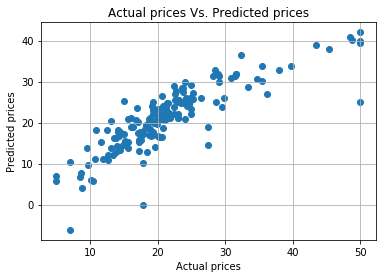

In [0]:
scatter_plot(test_y, pred_sklearn_100)

#### For manual SGD implementation

In [0]:
train_df = pd.DataFrame(data=train_data, copy=True)
train_df['Price'] = train_y

In [0]:
w_100, b_100 = sgd_implementation(train_df)
pred_sgd_100 = predict(test_data, w_100, b_100)

In [0]:
print("Error for manual sgd implementation after 100 iterations: ", mean_squared_error(test_y, pred_sgd_100))
print("Weight is :\n {}".format(w_100))
print("Intercept term is: ", b_100)

Error for manual sgd implementation after 100 iterations:  33.78431087504259
Weight is :
 [[-0.89926032  0.25154223  0.1772469   1.08923326 -0.32708322  3.49396942
  -0.14076727 -0.87730875  0.21005323 -0.24886133 -2.13666596  1.01351723
  -2.97403596]]
Intercept term is:  [19.57741673]


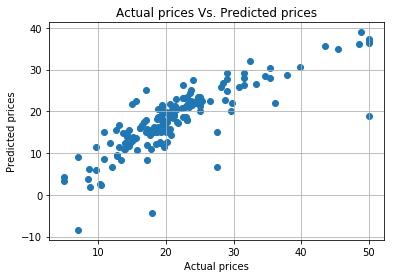

In [0]:
scatter_plot(test_y, pred_sgd_100)

## Compare sklearn and sgd_implementation using n_iterations = 1000

#### For sklearn implementation

In [0]:
clf = SGDRegressor(max_iter=1000)
clf.fit(train_data, train_y)
pred_sklearn_1000 = clf.predict(test_data)

In [0]:
print("Error for sklearn sgd implementation after 1000 iterations: ", mean_squared_error(test_y, pred_sklearn_1000))
print("Weight is :\n {}".format(clf.coef_))
print("Intercept term is: ", clf.intercept_)

Error for sklearn sgd implementation after 1000 iterations:  20.726360706969746
Weight is :
 [-1.09687073  0.87185159  0.40847462  0.83661364 -1.86756239  2.73338257
 -0.34817195 -3.00636956  2.04931344 -1.37080041 -2.00890507  1.08666279
 -3.9147427 ]
Intercept term is:  [22.47366505]


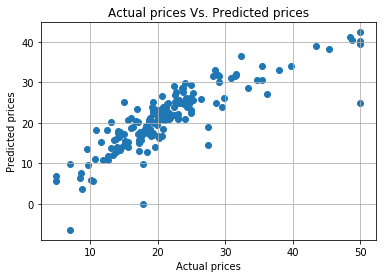

In [0]:
scatter_plot(test_y, pred_sklearn_1000)

#### For manual SGD implementation

In [0]:
w_1000, b_1000 = sgd_implementation(train_df, n_iterations=1000)
pred_sgd_1000 = predict(test_data, w_1000, b_1000)

In [0]:
print("Error for manual sgd implementation after 1000 iterations: ", mean_squared_error(test_y, pred_sgd_1000))
print("Weight is :\n {}".format(w_1000))
print("Intercept term is: ", b_1000)

Error for manual sgd implementation after 1000 iterations:  20.81177215115305
Weight is :
 [[-0.94896473  0.84205336  0.1922698   0.73364813 -1.66744882  2.59271305
  -0.20216335 -2.77045631  1.24621491 -0.67980862 -2.05784228  1.03525326
  -3.79131468]]
Intercept term is:  [22.39333658]


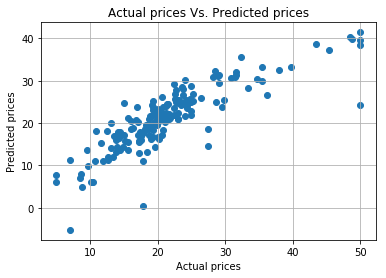

In [0]:
scatter_plot(test_y, pred_sgd_1000)

## Compare sklearn and sgd_implementation using n_iterations = 10000

#### For sklearn implementation

In [0]:
clf = SGDRegressor(max_iter=10000)
clf.fit(train_data, train_y)
pred_sklearn_10000 = clf.predict(test_data)

In [0]:
print("Error for sklearn sgd implementation after 1000 iterations: ", mean_squared_error(test_y, pred_sklearn_10000))
print("Weight is :\n {}".format(clf.coef_))
print("Intercept term is: ", clf.intercept_)

Error for sklearn sgd implementation after 1000 iterations:  20.7546916920261
Weight is :
 [-1.10069622  0.88270257  0.39936125  0.82088831 -1.88043881  2.73259252
 -0.35981524 -2.99221999  2.03696632 -1.37942602 -2.01195221  1.08713164
 -3.91551559]
Intercept term is:  [22.46538051]


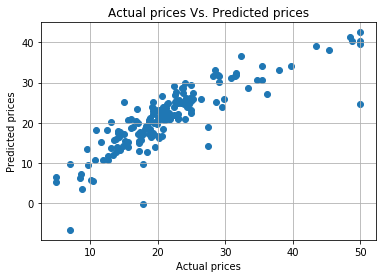

In [0]:
scatter_plot(test_y, pred_sklearn_10000)

#### For manual SGD implementation

In [0]:
w_10000, b_10000 = sgd_implementation(train_df, n_iterations=10000)
pred_sgd_10000 = predict(test_data, w_10000, b_10000)

In [0]:
print("Error for manual sgd implementation after 1000 iterations: ", mean_squared_error(test_y, pred_sgd_10000))
print("Weight is :\n {}".format(w_10000))
print("Intercept term is: ", b_10000)

Error for manual sgd implementation after 1000 iterations:  20.776502576858324
Weight is :
 [[-0.99594771  0.8386818   0.22409765  0.80894536 -1.85876814  2.72623608
  -0.28027622 -2.9716667   1.68529488 -1.00732216 -1.96511343  1.09662089
  -3.95757339]]
Intercept term is:  [22.45664395]


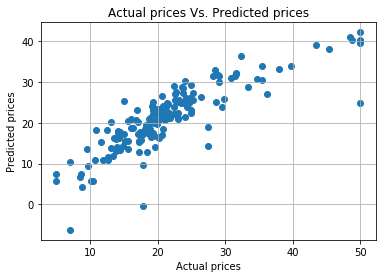

In [0]:
scatter_plot(test_y, pred_sgd_10000)

# Conclusion: 

| Model | Learning rate  | iterations  | Error | Intercept |
|----------:|--------|--------------|--------|-----------|
| Sklearn SGD| 0.01 | 100 | 20.80 | 22.46|
| Manual SGD | 0.01 | 100 | 33.78 | 19.57|
| Sklearn SGD| 0.01 | 1000 | 20.72 | 22.47|
| Manual SGD | 0.01 | 1000 | 20.81 | 22.39|
| Sklearn SGD| 0.01 | 10000 | 20.75 | 22.46|
| Manual SGD | 0.01 | 10000 | 20.77 | 22.45|


- From the above table it can be clearly stated that with the increase in the number of iterations, the model's probability to find a point that is a local or global minima increases. 
- For 100 iterations, the sklearn and manual SGD error rate was varying quite a lot (20.8 and 33.78 respectively) but as the number of iteration increased, at 10000 iterations the error rate and also the intercept term are almost equal (20.75 and 20.77) which means our model is almost similar in performance with the sklearn's SGDRegressor implementation. 

